<a href="https://colab.research.google.com/github/Kanav30/Federated-Spatio-Temporal-Graph-Network/blob/main/Federated_Spatio_Temporal_Graph_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import os

#Loading the file
file_path = "/content/drive/MyDrive/metr-la.h5"

if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure you have uploaded the 'metr-la (1).h5' file to your Colab environment's /content/ directory.")
else:
    with h5py.File(file_path, "r") as f:
        print(list(f.keys()))

['df']


In [4]:
#read traffic speed data
with h5py.File(file_path, "r") as f:
    df_group = f["df"]
    speed_data = df_group["block0_values"][:]

print(speed_data.shape)

(34272, 207)


In [5]:
#One row
print(speed_data[0])

[64.375      67.625      67.125      61.5        66.875      68.75
 65.125      67.125      59.625      62.75       55.5        66.5
 64.25       68.5        60.375      67.5        37.75       63.125
 59.75       62.125      67.25       41.25       54.625      58.125
 65.125      64.25       61.25       62.75       66.875      47.375
 57.         67.75       65.125      66.875      64.         62.
 64.375      60.75       60.75       62.375      64.5        66.
 62.         64.875      55.875      67.75       63.         60.125
 60.25       62.25       42.25       48.25       65.125      63.5
 55.75       60.5        51.57142857 60.25       63.875      59.875
 64.625      64.         52.5        66.25       68.25       68.875
 66.375      64.5        67.875      67.25       63.125      66.25
 64.625      59.125      68.25       52.25       58.125      61.25
 66.125      69.375      69.75       63.5        64.25       68.
 56.875      64.375      65.25       65.75       61.25       63.

In [6]:
#Missing value

print("NaNs before:", np.isnan(speed_data).sum())
mean_value = np.nanmean(speed_data)
speed_data = np.nan_to_num(speed_data, nan=mean_value)

print("NaNs after:", np.isnan(speed_data).sum())


NaNs before: 0
NaNs after: 0


In [7]:
#Normalizing
mean = speed_data.mean()
std = speed_data.std()

speed_data = (speed_data - mean) / std

In [8]:
#Samples of the data

INPUT_WINDOW = 12
OUTPUT_WINDOW = 12

def create_samples(data, input_window, output_window):
    X, Y = [], []
    T = data.shape[0]

    for t in range(input_window, T - output_window):
        past = data[t - input_window:t]      #past 12 steps
        future = data[t:t + output_window]   #next 12 steps

        X.append(past)
        Y.append(future)

    return np.array(X), np.array(Y)


In [9]:
X, Y = create_samples(speed_data, INPUT_WINDOW, OUTPUT_WINDOW)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (34248, 12, 207)
Y shape: (34248, 12, 207)


In [10]:
X = X[..., np.newaxis]
Y = Y[..., np.newaxis]

print(X.shape)
print(Y.shape)


(34248, 12, 207, 1)
(34248, 12, 207, 1)


In [11]:
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)


In [12]:
class METRLADataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [13]:
dataset = METRLADataset(X, Y)

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

In [14]:
for xb, yb in dataloader:
    print("Input batch:", xb.shape)
    print("Target batch:", yb.shape)
    break

Input batch: torch.Size([32, 12, 207, 1])
Target batch: torch.Size([32, 12, 207, 1])


In [15]:
import pickle

with open("/content/drive/MyDrive/adj_mx.pkl", "rb") as f:
    sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f, encoding='latin1')
print(adj_mx.shape)

(207, 207)


In [16]:
#Convert to PyTorch Sensor
import torch

adj = torch.tensor(adj_mx, dtype=torch.float32)


def normalize_adj(adj):
    adj = adj + torch.eye(adj.size(0), device=adj.device)
    degree = torch.sum(adj, dim=1)
    degree_inv_sqrt = torch.pow(degree, -0.5)
    degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0.0
    D_inv_sqrt = torch.diag(degree_inv_sqrt)
    return D_inv_sqrt @ adj @ D_inv_sqrt

adj_norm = normalize_adj(adj)

In [17]:
import torch
import torch.nn as nn

class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, adj):
        # x: [batch, time, nodes, features]
        x = torch.einsum("btnf,nm->btmf", x, adj)
        x = self.linear(x)
        return x


class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(3, 1),
            padding=(1, 0)
        )

    def forward(self, x):
        # x: [batch, time, nodes, features]
        x = x.permute(0, 3, 1, 2)  # [batch, features, time, nodes]
        x = self.conv(x)
        x = x.permute(0, 2, 3, 1)  # back to [batch, time, nodes, features]
        return x


class STGCN(nn.Module):
    def __init__(self, num_nodes):
        super().__init__()

        self.gc1 = GraphConv(1, 32)
        self.tc1 = TemporalConv(32, 32)

        self.gc2 = GraphConv(32, 32)
        self.tc2 = TemporalConv(32, 32)

        self.output_layer = nn.Linear(32, 1)

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = torch.relu(x)

        x = self.tc1(x)
        x = torch.relu(x)

        x = self.gc2(x, adj)
        x = torch.relu(x)

        x = self.tc2(x)
        x = torch.relu(x)

        x = self.output_layer(x)

        return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = STGCN(num_nodes=207).to(device)
adj_norm = adj_norm.to(device)

In [19]:
x_batch, y_batch = next(iter(dataloader))

x_batch = x_batch.to(device)

with torch.no_grad():
    output = model(x_batch, adj_norm)

print("Input shape :", x_batch.shape)
print("Output shape:", output.shape)

Input shape : torch.Size([32, 12, 207, 1])
Output shape: torch.Size([32, 12, 207, 1])


In [20]:
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)
model = model.to(device)
adj_norm = adj_norm.to(device)

In [21]:
#The training loop

def train_model(model, dataloader, adj, criterion, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0

        for x_batch, y_batch in dataloader:
            # Move data to device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(x_batch, adj)

            # Compute loss
            loss = criterion(output, y_batch)

            # Backpropagation
            loss.backward()

            # Update weights
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.6f}")

In [29]:
train_model(
    model,
    dataloader,
    adj_norm,
    criterion,
    optimizer,
    epochs=15
)

Epoch [1/15] - Loss: 0.438029
Epoch [2/15] - Loss: 0.436613
Epoch [3/15] - Loss: 0.435898
Epoch [4/15] - Loss: 0.434906
Epoch [5/15] - Loss: 0.433509
Epoch [6/15] - Loss: 0.432800
Epoch [7/15] - Loss: 0.431343
Epoch [8/15] - Loss: 0.430430
Epoch [9/15] - Loss: 0.429212
Epoch [10/15] - Loss: 0.428720
Epoch [11/15] - Loss: 0.427766
Epoch [12/15] - Loss: 0.427008
Epoch [13/15] - Loss: 0.426121
Epoch [14/15] - Loss: 0.425978
Epoch [15/15] - Loss: 0.425880


In [23]:
model.eval()

with torch.no_grad():
    x_batch, y_batch = next(iter(dataloader))
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    predictions = model(x_batch, adj_norm)

    mae = torch.mean(torch.abs(predictions - y_batch))
    print("MAE:", mae.item())

MAE: 0.4365385174751282


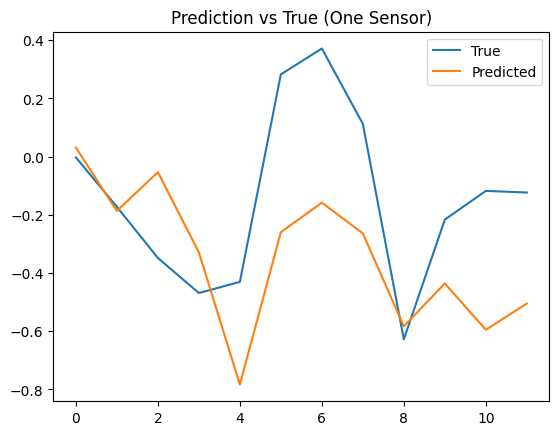

Correlation: 0.4656213533639834
True: [-0.00258395 -0.17258401 -0.34806794 -0.46871313 -0.43032604  0.28257746
  0.3716904   0.11257739 -0.62774545 -0.21645498 -0.11774527 -0.12322915]
Pred: [ 0.03101426 -0.18658298 -0.05336121 -0.328875   -0.78298616 -0.25971425
 -0.15801512 -0.26381308 -0.5830854  -0.43579686 -0.595056   -0.50491035]


In [36]:
import matplotlib.pyplot as plt

sensor_id = 50  # pick any sensor

true_values = y_batch[0, :, sensor_id, 0].cpu().numpy()
pred_values = predictions[0, :, sensor_id, 0].cpu().numpy()

plt.plot(true_values, label="True")
plt.plot(pred_values, label="Predicted")
plt.legend()
plt.title("Prediction vs True (One Sensor)")
plt.show()

import numpy as np
print("Correlation:", np.corrcoef(true_values, pred_values)[0,1])
print("True:", true_values)
print("Pred:", pred_values)

In [47]:
#Four regions for now
import numpy as np

NUM_CLIENTS = 4

#Splitting sensors into clusters
num_sensors = speed_data.shape[1]

sensor_indices = np.arange(num_sensors)

clusters = np.array_split(sensor_indices, NUM_CLIENTS)

for i, cluster in enumerate(clusters):
    print(f"Client {i} has {len(cluster)} sensors")

#Local speed data per client
client_speed_data = []

for cluster in clusters:
    client_speed_data.append(speed_data[:, cluster])
    print(f"Client speed data shape: {client_speed_data[-1].shape}")

Client 0 has 52 sensors
Client 1 has 52 sensors
Client 2 has 52 sensors
Client 3 has 51 sensors
Client speed data shape: (34272, 52)
Client speed data shape: (34272, 52)
Client speed data shape: (34272, 52)
Client speed data shape: (34272, 51)


In [50]:
#Local adjacency subgraphs
client_adj_matrices = []

for cluster in clusters:
    sub_adj = adj_norm[np.ix_(cluster, cluster)]
    client_adj_matrices.append(sub_adj)
    print(client_adj_matrices[0].shape)

torch.Size([52, 52])
torch.Size([52, 52])
torch.Size([52, 52])
torch.Size([52, 52])


In [53]:
#Sliding windows per client
client_dataloaders = []

for i in range(NUM_CLIENTS):

    X_client, Y_client = create_samples(
        client_speed_data[i],
        INPUT_WINDOW,
        OUTPUT_WINDOW
    )

    X_client = X_client[..., np.newaxis]
    Y_client = Y_client[..., np.newaxis]

    X_client = torch.tensor(X_client, dtype=torch.float32)
    Y_client = torch.tensor(Y_client, dtype=torch.float32)

    dataset = METRLADataset(X_client, Y_client)

    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True
    )

    client_dataloaders.append(dataloader)

for i in range(NUM_CLIENTS):
  xb, yb = next(iter(client_dataloaders[i]))
  print(f"Client {i} batch shape:", xb.shape)

Client 0 batch shape: torch.Size([32, 12, 52, 1])
Client 1 batch shape: torch.Size([32, 12, 52, 1])
Client 2 batch shape: torch.Size([32, 12, 52, 1])
Client 3 batch shape: torch.Size([32, 12, 51, 1])
